In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:100% !important; }</style>"))

/tmp/ipykernel_3843/196557437.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML, clear_output
/tmp/ipykernel_3843/196557437.py:1: DeprecationWarning: Importing clear_output from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML, clear_output


In [3]:
import pandas as pd
import numpy as np
from scipy import optimize
from scipy.stats import sem

import os
import sys

import matplotlib.pyplot as plt
import matplotlib.ticker
from venn import venn, pseudovenn
import seaborn as sns
from matplotlib.collections import PathCollection

from Bio import SeqIO, SeqUtils
from Bio.SeqUtils.ProtParam import ProteinAnalysis

from addict import Dict
import json


In [5]:
sys.path.append("../")
import plotting as my_plot

sys.path.append("./mean_field_elect/")
import proteomics_functions as prot_fun

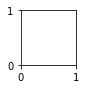

In [5]:
fig, ax = my_plot.instantiate_fig(1, 1)

In [6]:
df_aex = pd.read_csv('./generated_tables/swath_master_df_ppm.csv')
df_prev = pd.read_csv('./generated_tables/prev_swath_master_df_ppm.csv')
df_prop = pd.read_csv('./generated_tables/swath_master_df_ppm_with_properties.csv')
df_prev_prop = pd.read_csv('./generated_tables/prev_swath_master_df_ppm_with_properties.csv')

df_all = df_prev.merge(df_aex, how='outer')
df_all = df_all.fillna(0)

df_log = df_all.drop(columns=['accn', 'name'])
df_log = df_log.fillna(0)
df_log = np.log10(df_log)
df_log.replace(-1*np.inf, np.nan, inplace=True)

/home/chase/psi4conda/envs/jupyter/lib/python3.11/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


In [7]:
resins = ['cq', 'xq', 'hq']
fracs = ['a5', 'b12', 'd9', 'g12', 'eluate']
loadings = ['5% Loading', '28% Loading', '53% Loading', '99% Loading', 'adsorbate']

resin_names = {'cq':'Capto Q', 'xq':'Poros XQ', 'hq':'Poros 50 HQ'}
frac_names = {'a5':'A5', 'b12':'B12', 'd9':'D9', 'g12':'G12', 'eluate':'adsorbate'}
percent_loading = {'a5':'5%', 'b12':'28%', 'd9':'53%', 'g12':'99%', 'eluate':'adsorbate'}

# $c$ distributions

In [8]:
log10_label = r'$\mathsf{log_{10}\left(c_{HCP} \; [ppm \; = \; ng \; HCP \; / \; mg \; total]\right)}$'

sample = 'pavin_feed'
df_violin_c = pd.DataFrame()
df_violin_c[log10_label] = df_log[df_log[sample].notnull()][sample].copy()
df_violin_c['sample_name'] = 'PAVIN Feed'

for resin in resins:
    for frac in fracs:
        sample = f'{resin}_{frac}'
        label = f'{resin_names[resin]} {percent_loading[frac]}'
        df_temp = pd.DataFrame()
        df_temp[log10_label] = df_log[df_log[sample].notnull()][sample].copy()
        df_temp['sample_name'] = label
        df_violin_c = pd.concat([df_violin_c, df_temp], ignore_index=True)

In [9]:
color_map = {'PAVIN Feed':0}
for resin in resins:
    for j, frac in enumerate(fracs):
        label = f'{resin_names[resin]} {percent_loading[frac]}'
        color_map[label] = j + 1
        
index_color_map = {}
for i, cont in df_violin_c.iterrows():
    index_color_map[i] = color_map[cont['sample_name']]

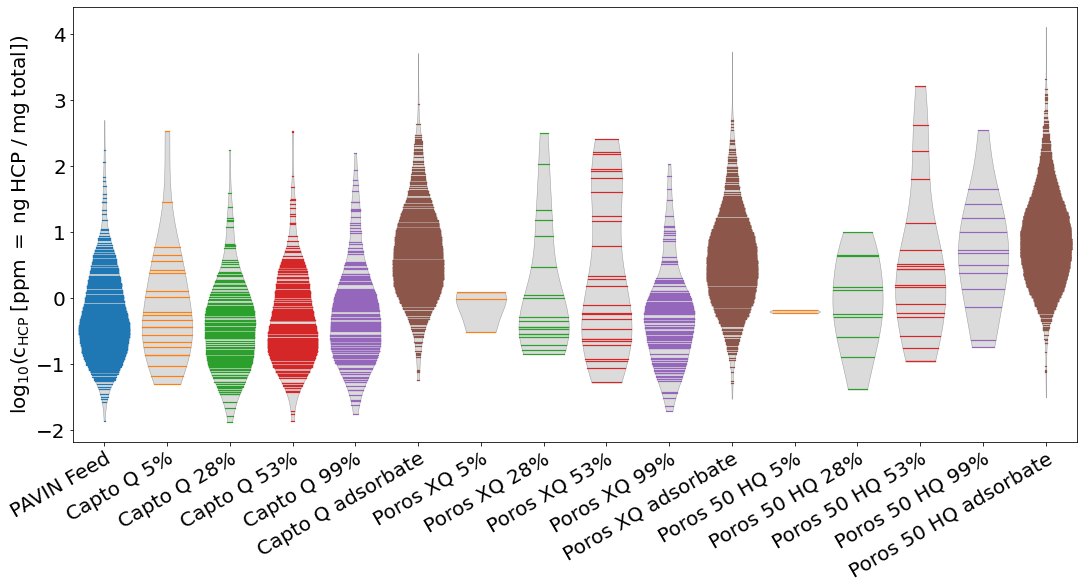

In [10]:
plt.gcf().set_size_inches(18, 8)

xlabel = "sample_name"
ylabel = log10_label
df = df_violin_c

ax = sns.violinplot(x=xlabel, y=ylabel, data=df, linewidth=0.5, scale='width', color='0.8', inner='stick', cut=0)

for violin in ax.collections:
    violin.set_alpha(0.7)
    
for i, line in enumerate(ax.lines):
    color_index = index_color_map[i]
    line.set_color(f'C{color_index}')
    line.set_linewidth(1.2)
    
labels = ax.set_xticklabels(ax.get_xticklabels(),rotation=30, ha="right", rotation_mode='anchor')
hide = ax.set(xlabel=None)

# plt.savefig('./images/6c_violin_with_sticks_c.png', dpi=300, bbox_inches='tight')

# pI

In [11]:
violin_label = 'Isoelectric point'
prop = 'pI'

sample = 'pavin_feed'
df_violin_pI = pd.DataFrame()
df_violin_pI[violin_label] = df_prev_prop[df_prev_prop[sample] > 0.0][prop].copy()
df_violin_pI['sample_name'] = 'PAVIN Feed'

for resin in resins:
    for frac in fracs:
        sample = f'{resin}_{frac}'
        df_temp = pd.DataFrame()
        df_temp[violin_label] = df_prop[df_prop[sample] > 0.0][prop].copy()
        df_temp['sample_name'] = f'{resin_names[resin]} {percent_loading[frac]}'
        df_violin_pI = pd.concat([df_violin_pI, df_temp], ignore_index=True)

In [12]:
# This should be redundant since it was already done above and the number of HCPs in each sample is the same

color_map = {'PAVIN Feed':0}
for resin in resins:
    for j, frac in enumerate(fracs):
        label = f'{resin_names[resin]} {percent_loading[frac]}'
        color_map[label] = j + 1
        
index_color_map = {}
for i, cont in df_violin_pI.iterrows():
    index_color_map[i] = color_map[cont['sample_name']]

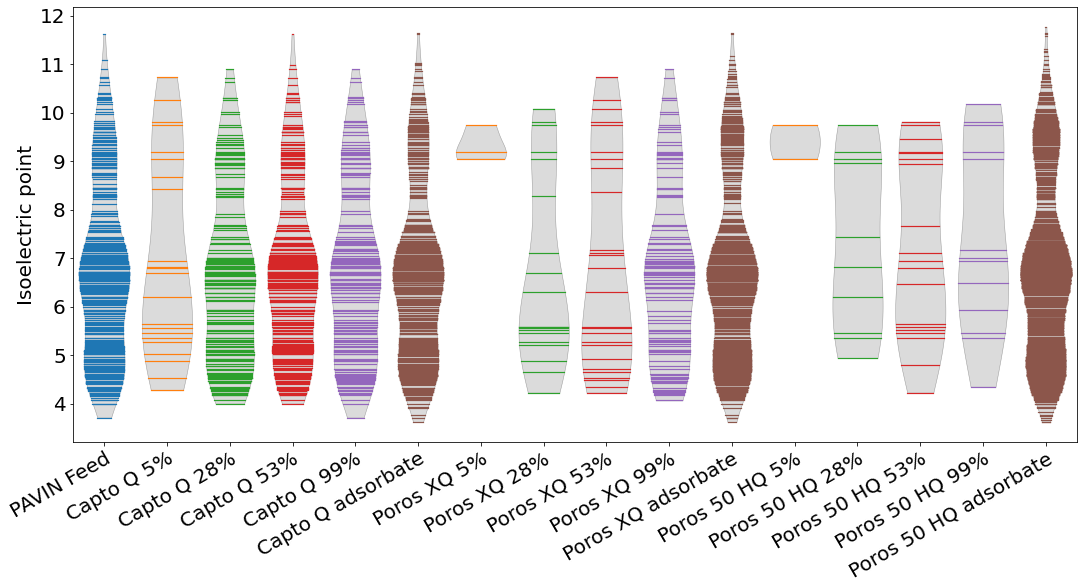

In [13]:
plt.gcf().set_size_inches(18, 8)

xlabel = "sample_name"
ylabel = violin_label
df = df_violin_pI

ax = sns.violinplot(x=xlabel, y=ylabel, data=df, linewidth=0.5, scale='width', color='0.8', inner='stick', cut=0)

for violin in ax.collections:
    violin.set_alpha(0.7)
    
for i, line in enumerate(ax.lines):
    color_index = index_color_map[i]
    line.set_color(f'C{color_index}')
    line.set_linewidth(1.2)
    
labels = ax.set_xticklabels(ax.get_xticklabels(),rotation=30, ha="right", rotation_mode='anchor')
hide = ax.set(xlabel=None)

# plt.savefig('./images/6c_violin_with_sticks_pI.png', dpi=300, bbox_inches='tight')

# Mass

In [14]:
violin_label = 'Molecular mass [kDa]'
prop = 'mass'

sample = 'pavin_feed'
df_violin_mass = pd.DataFrame()
df_violin_mass[violin_label] = df_prev_prop[df_prev_prop[sample] > 0.0][prop].copy()
df_violin_mass['sample_name'] = 'PAVIN Feed'

for resin in resins:
    for frac in fracs:
        sample = f'{resin}_{frac}'
        df_temp = pd.DataFrame()
        df_temp[violin_label] = df_prop[df_prop[sample] > 0.0][prop].copy()
        df_temp['sample_name'] = f'{resin_names[resin]} {percent_loading[frac]}'
        df_violin_mass = pd.concat([df_violin_mass, df_temp], ignore_index=True)
        
df_violin_mass[violin_label] *= 1e-3

In [15]:
# This should be redundant since it was already done above and the number of HCPs in each sample is the same

color_map = {'PAVIN Feed':0}
for resin in resins:
    for j, frac in enumerate(fracs):
        label = f'{resin_names[resin]} {percent_loading[frac]}'
        color_map[label] = j + 1
        
index_color_map = {}
for i, cont in df_violin_mass.iterrows():
    index_color_map[i] = color_map[cont['sample_name']]

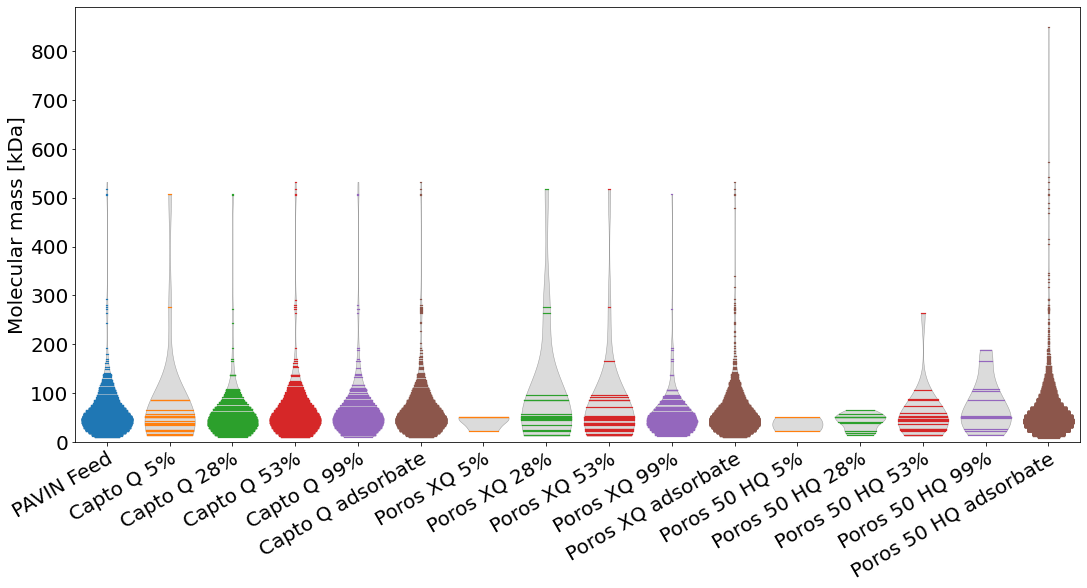

In [16]:
plt.gcf().set_size_inches(18, 8)

xlabel = "sample_name"
ylabel = violin_label
df = df_violin_mass

ax = sns.violinplot(x=xlabel, y=ylabel, data=df, linewidth=0.5, scale='width', color='0.8', inner='stick', cut=0)

for violin in ax.collections:
    violin.set_alpha(0.7)
    
for i, line in enumerate(ax.lines):
    color_index = index_color_map[i]
    line.set_color(f'C{color_index}')
    line.set_linewidth(1.2)
    
labels = ax.set_xticklabels(ax.get_xticklabels(),rotation=30, ha="right", rotation_mode='anchor')
hide = ax.set(xlabel=None)
ylim = ax.set_ylim(0, None)

# plt.savefig('./images/6c_violin_with_sticks_molecular_mass.png', dpi=300, bbox_inches='tight')

# $c$ and pI

In [17]:
def plot_violin(ylabel, df, ax, index_color_map, xlabel='sample_name'):
    return_ax = sns.violinplot(x=xlabel, y=ylabel, data=df, linewidth=0.5, scale='width', color='0.8', inner='stick', cut=0, ax=ax)

    for violin in ax.collections:
        violin.set_alpha(0.7)

    for i, line in enumerate(ax.lines):
        color_index = index_color_map[i]
        line.set_color(f'C{color_index}')
        line.set_linewidth(1.2)
        
    return return_ax

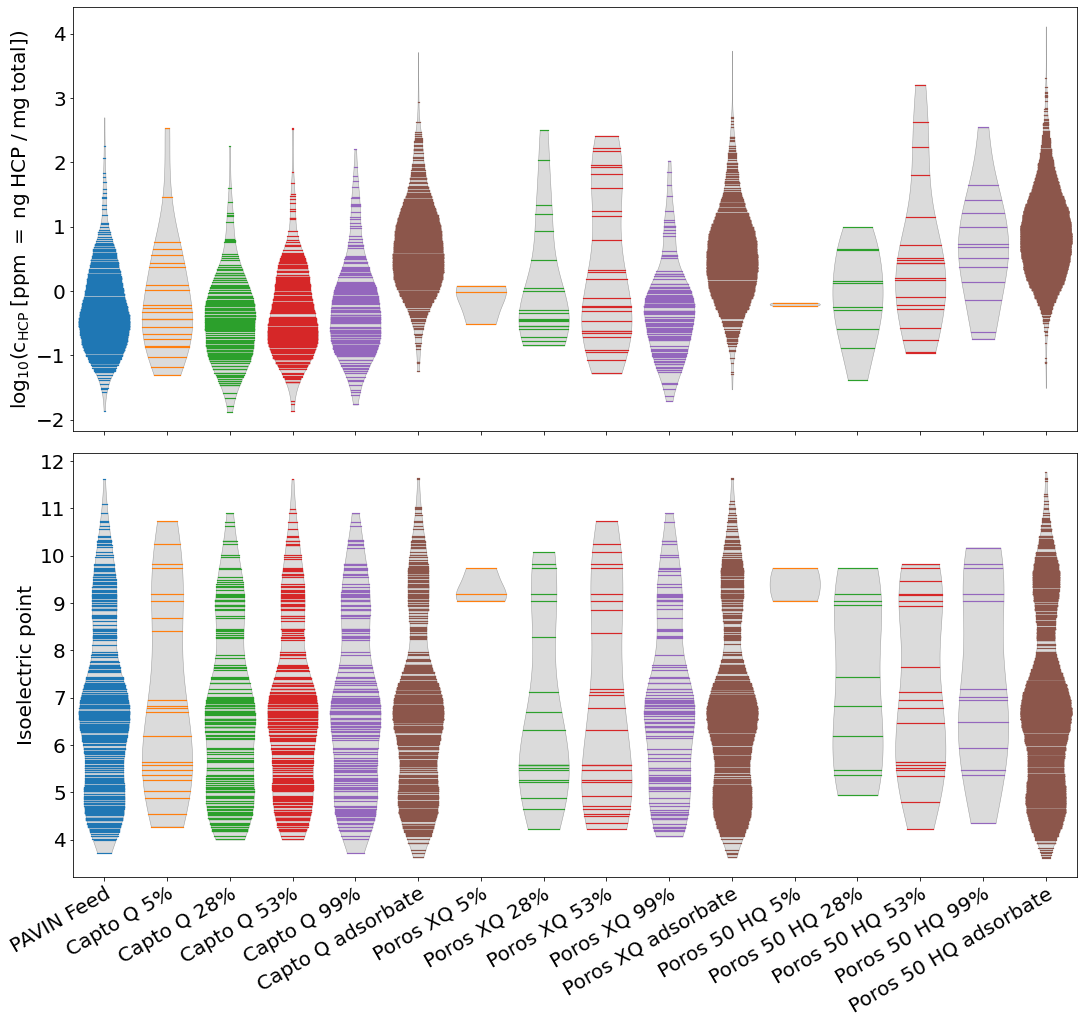

In [18]:
fig, ax = plt.subplots(2, 1, sharex=True)
fig.set_size_inches(18, 16, forward=True)

return_ax_0 = plot_violin(log10_label, df_violin_c, ax[0], index_color_map)
return_ax_1 = plot_violin('Isoelectric point', df_violin_pI, ax[1], index_color_map)

labels = ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=30, ha="right", rotation_mode='anchor')
for i in range(2):
    hide = ax[i].set(xlabel=None)
    
plt.subplots_adjust(hspace=0.05)

# plt.savefig('./images/6c_violin_with_sticks_c_and_pI.png', dpi=300, bbox_inches='tight')
# plt.savefig('./images/6c_violin_with_sticks_c_and_pI.pdf', bbox_inches='tight')

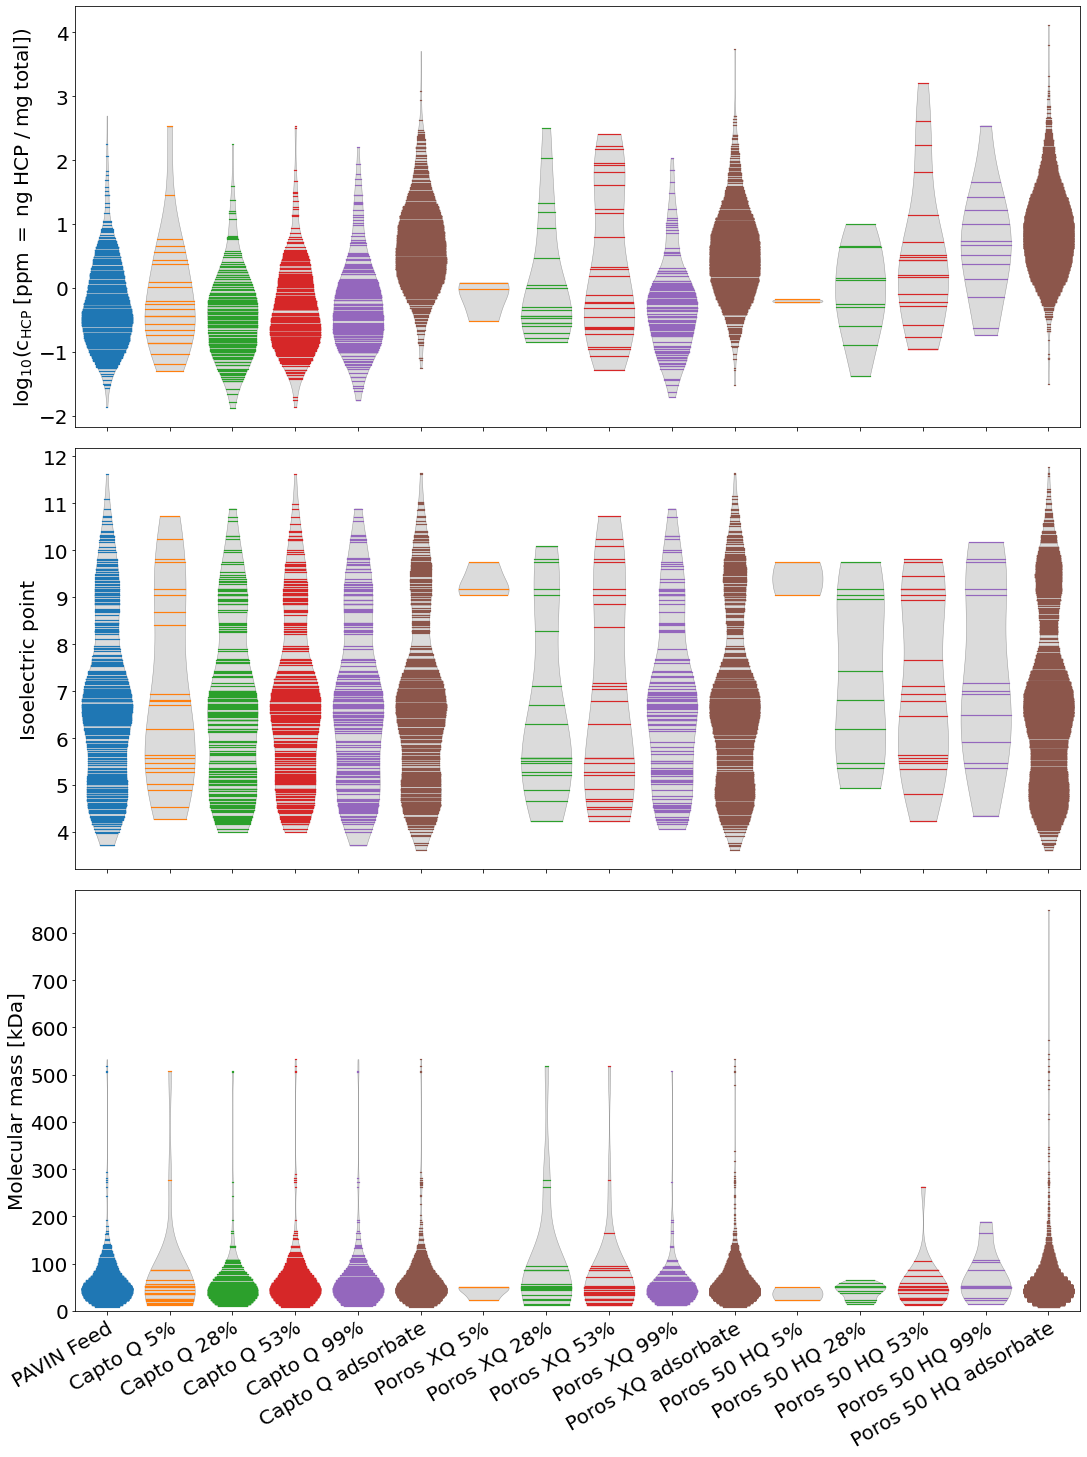

In [20]:
fig, ax = plt.subplots(3, 1, sharex=True)
fig.set_size_inches(18, 24, forward=True)

return_ax_0 = plot_violin(log10_label, df_violin_c, ax[0], index_color_map)
return_ax_1 = plot_violin('Isoelectric point', df_violin_pI, ax[1], index_color_map)
return_ax_2 = plot_violin('Molecular mass [kDa]', df_violin_mass, ax[2], index_color_map)

labels = ax[2].set_xticklabels(ax[2].get_xticklabels(),rotation=30, ha="right", rotation_mode='anchor')
for i in range(3):
    hide = ax[i].set(xlabel=None)
    
plt.subplots_adjust(hspace=0.05)
ylim = ax[2].set_ylim(0, None)

# plt.savefig('./images/6c_violin_with_sticks_c_and_pI_and_mass.png', dpi=300, bbox_inches='tight')
plt.savefig('./images/6c_violin_with_sticks_c_and_pI_and_mass.pdf', bbox_inches='tight')

In [58]:
# df_prop[(df_prop.xq_a5 > 0.0) | (df_prop.hq_a5 > 0.0)].to_csv('./generated_tables/species_in_poros_early_ft.csv', index=False)

In [60]:
df_prop[(df_prop.xq_a5 > 0.0) | (df_prop.hq_a5 > 0.0)]

,accn,name,cq_a5,cq_b12,cq_d9,cq_g12,cq_eluate,xq_a5,xq_b12,xq_d9,...,hq_eluate,sequence,pI,mass,net_charge,net_charge_neg,net_charge_pos,charge_dens_C_m2,charge_dens_neg_C_m2,charge_dens_pos_C_m2
5,NP_001231331.1,elongation factor 1-alpha 1 [Cricetulus griseus],3.599395,23.794650,31.637018,13.888194,162.000557,1.211681,1.114208,2.142272,...,899.422706,MGKEKTHINIVVIGHVDSGKSTTTGHLIYKCGGIDKRTIEKFEKEA...,9.743462,50113.2484,13.445714,-53.981443,67.427157,0.028827,-0.115733,0.144560
17,NP_001233694.1,peroxiredoxin-1 [Cricetulus griseus],0.552471,15.099034,18.689113,12.915817,153.079610,0.964092,0.165233,0.590459,...,1129.087840,MSSGNAKIGYPAPNFKATAVMPDGQFRDICLSEYRGKYVVFFFYPL...,9.049790,22262.3456,2.606514,-23.995205,26.601720,0.009598,-0.088360,0.097959
94,XP_027260201.1,serine protease HTRA1 isoform X3 [Cricetulus g...,2.353230,39.201990,71.228351,51.427645,429.108202,0.305042,0.505935,0.773356,...,6268.771008,MLSQRTALFSLLLLLLAAPSLALPSGTGRSASAATICPERCDPTRC...,9.184247,50200.2110,4.408824,-55.975028,60.383852,0.009441,-0.119868,0.129310
